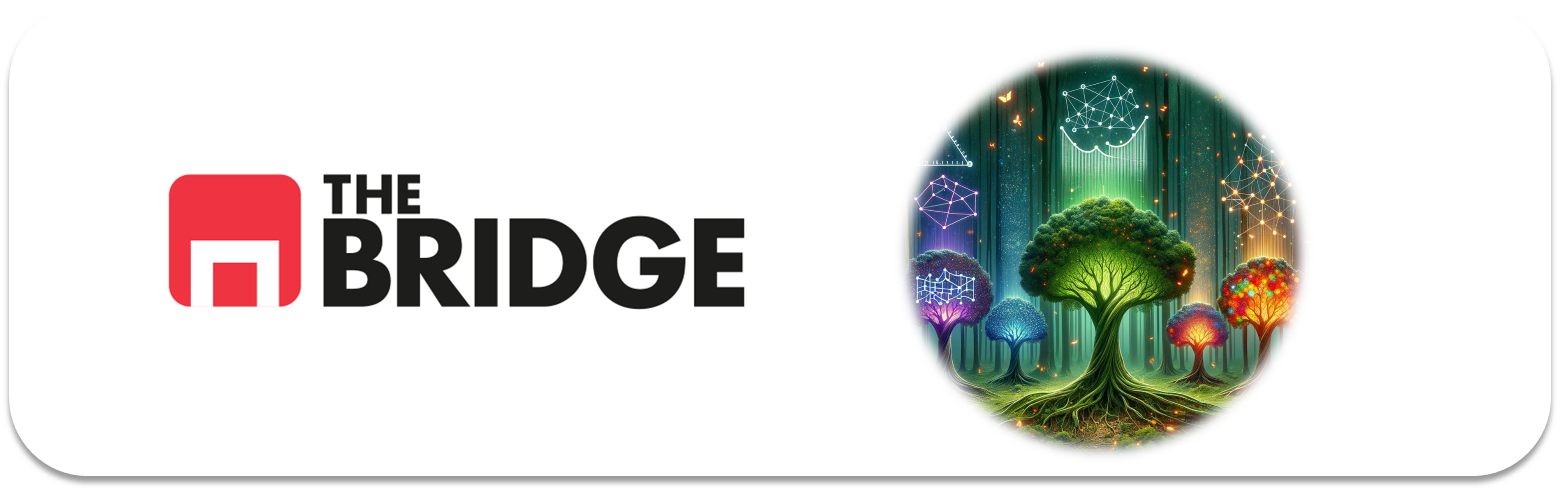

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc

#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

np.random.seed(42)

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [2]:
data = pd.read_csv("data/bank-full.csv", sep=';')

In [3]:
data.sample(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no
30813,28,blue-collar,married,secondary,no,1134,no,no,cellular,9,feb,130,3,-1,0,unknown,no
35463,24,management,single,tertiary,no,1085,no,yes,cellular,7,may,95,6,-1,0,unknown,no
31382,37,admin.,single,secondary,no,127,no,no,cellular,23,mar,83,4,-1,0,unknown,no
16904,30,blue-collar,single,secondary,no,3,yes,no,cellular,25,jul,51,1,-1,0,unknown,no
11930,38,technician,single,secondary,no,258,no,yes,unknown,20,jun,587,2,-1,0,unknown,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# Hago unas listas preliminares de features categóricas / numéricas para el mini-EDA posterior, aunque quizá aplique algunas transformaciones después

cats = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
nums = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

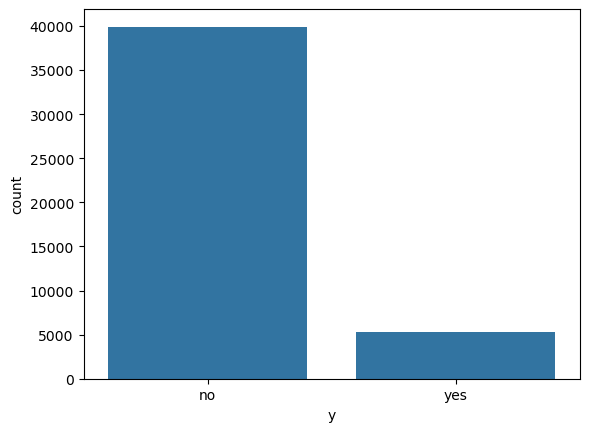

In [6]:
# Analizo la variable target

target = "y"

sns.countplot(data=data, x=target);

Distribución muy desigual. A tener en cuenta.

In [7]:
# Split

train_set, test_set = train_test_split(data, test_size= 0.1, random_state= 42)

### Mini-EDA

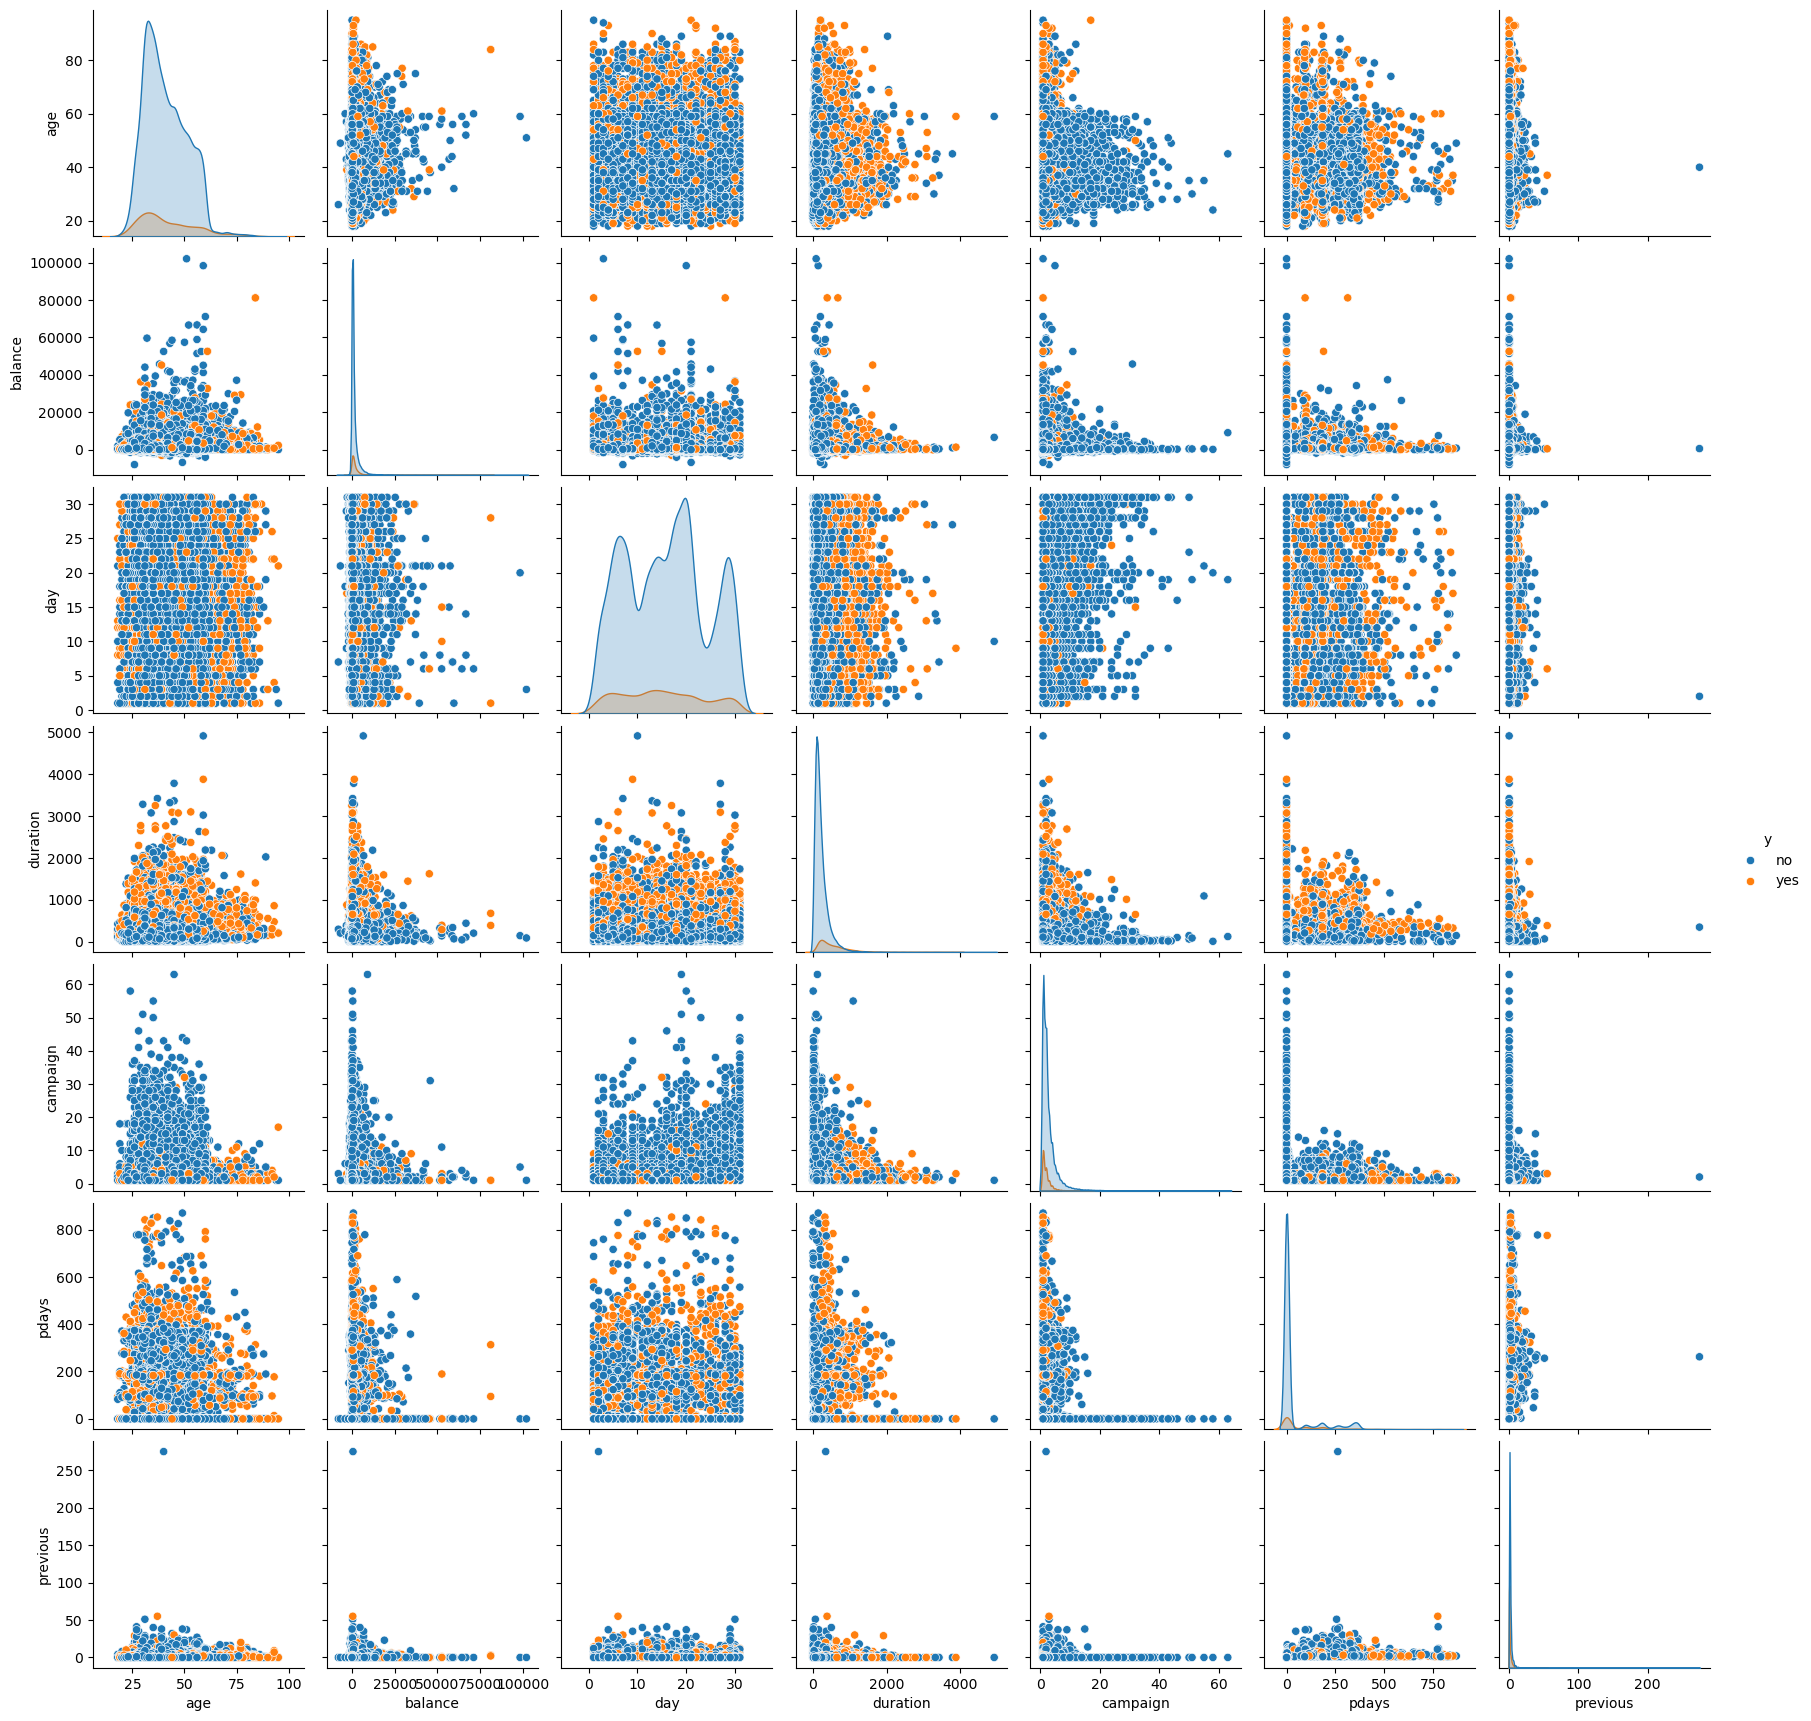

In [8]:
sns.pairplot(train_set[nums + [target]], hue = target)

In [9]:
nums = ["age", "day", "duration", "pdays"]

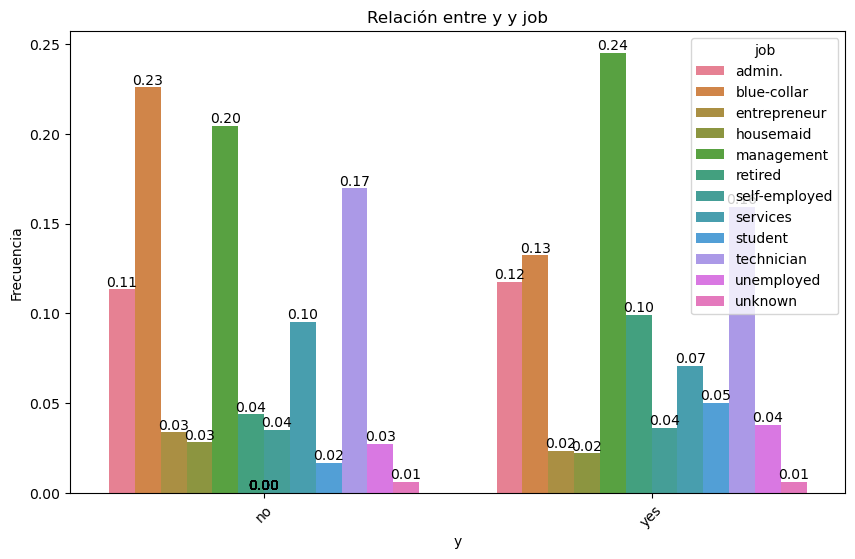

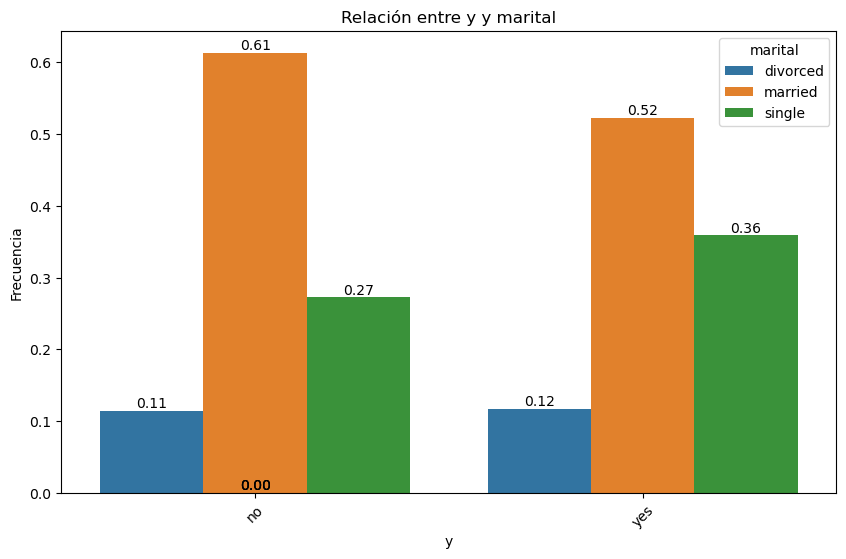

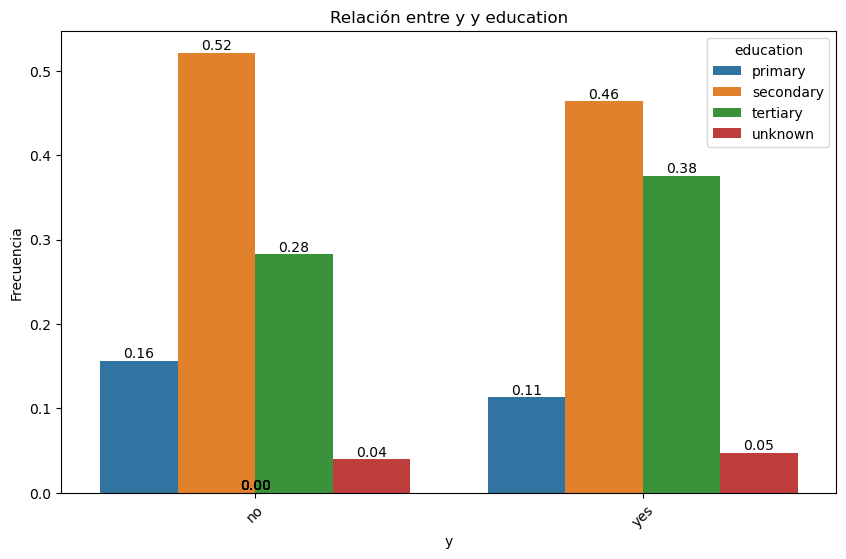

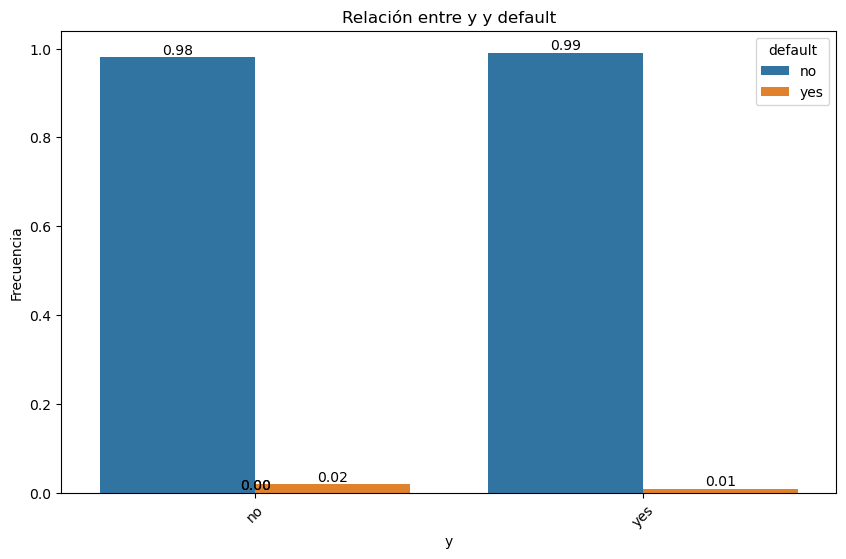

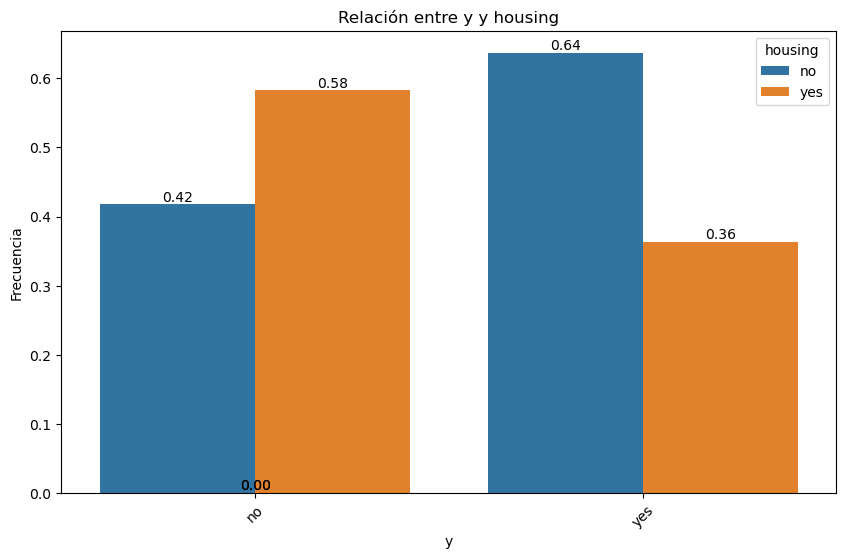

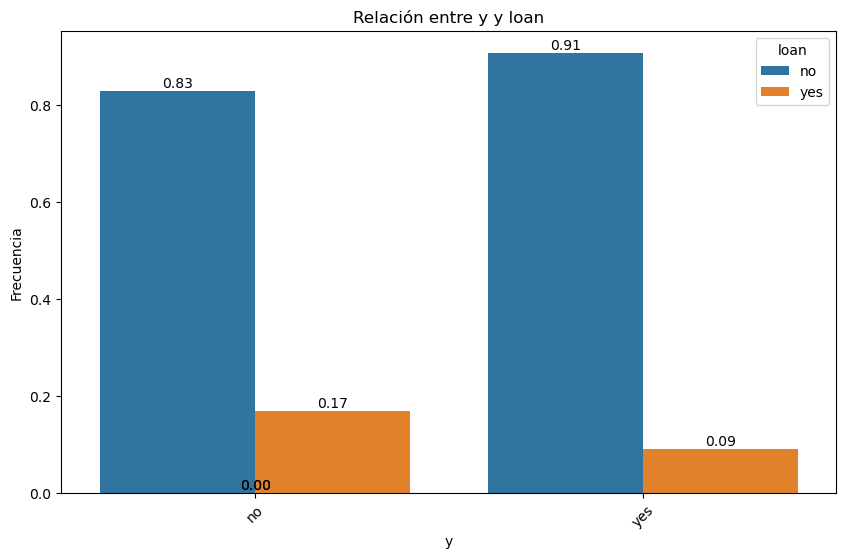

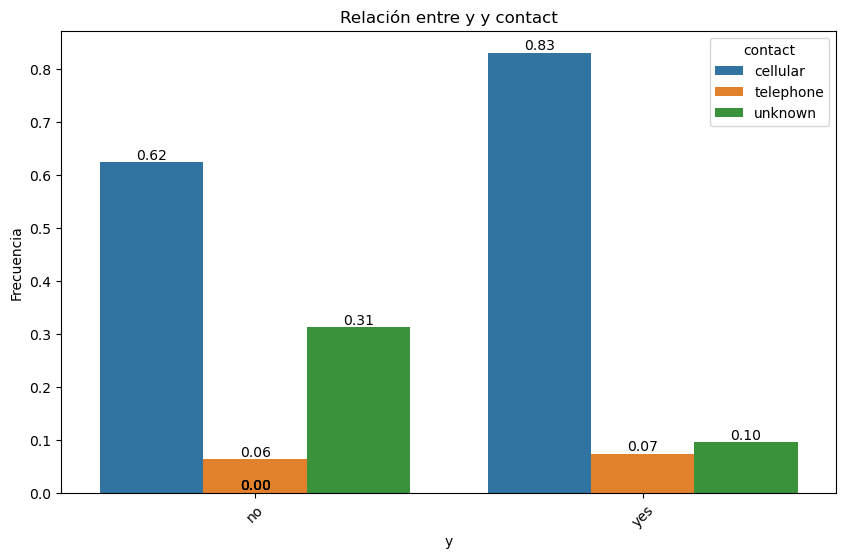

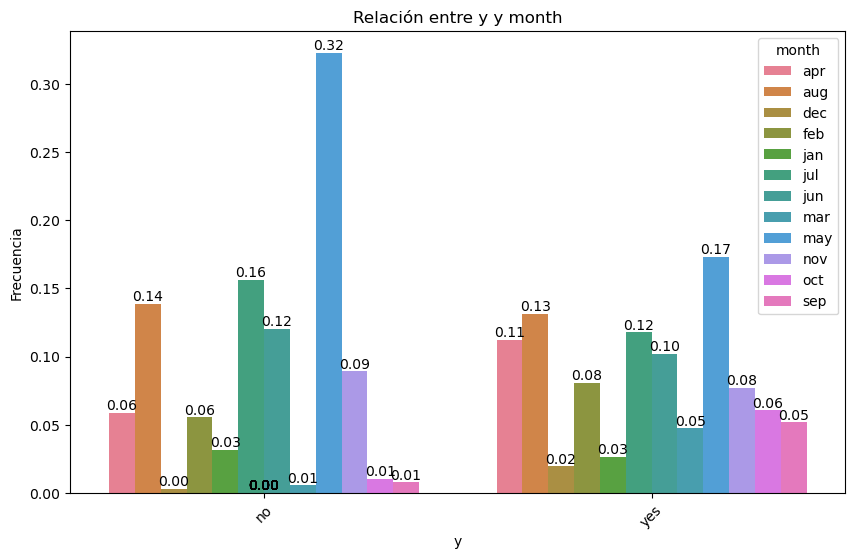

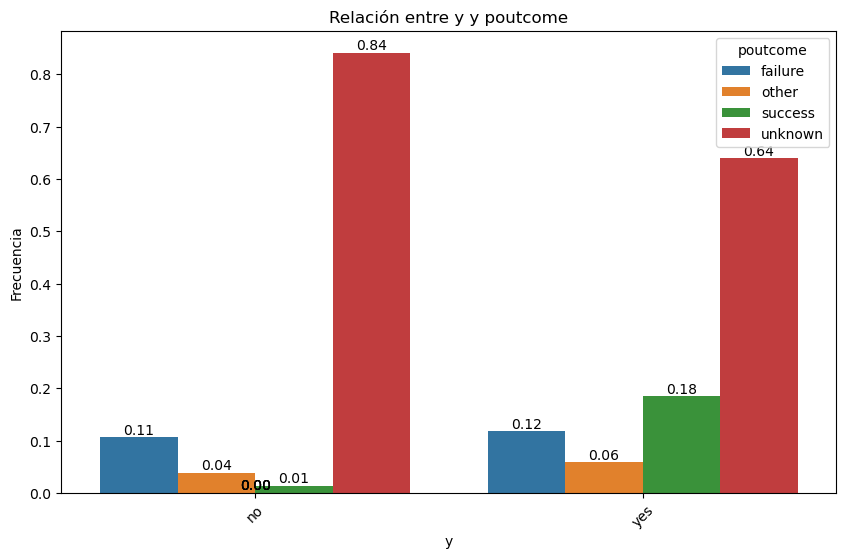

In [10]:
# Análisis visual categóricas

for feat in cats:
    bt.plot_categorical_relationship_fin(train_set, target, feat, show_values= True, relative_freq= True)

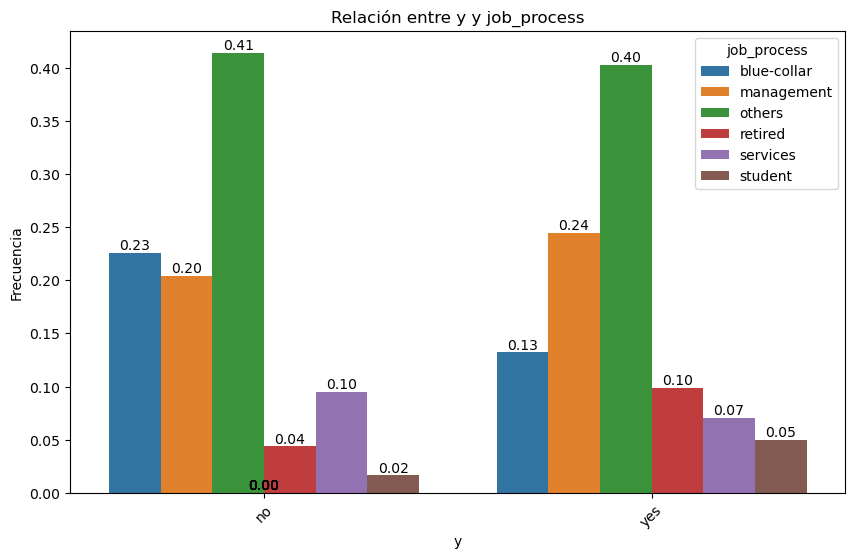

In [11]:
# Para job, algunas profesiones muestran diferencias y otras no. Quizá sea buena idea agrupar las que no:

train_set["job_process"] = pd.Series(np.where(np.isin(train_set.job.values, ["admin.", "entrepreneur", "housemaid", "self-employed", "technician", "unemployed", "unknown"]), "others", train_set.job.values), train_set.index)
test_set["job_process"] = pd.Series(np.where(np.isin(test_set.job.values, ["admin.", "entrepreneur", "housemaid", "self-employed", "technician", "unemployed", "unknown"]), "others", test_set.job.values), test_set.index)

bt.plot_categorical_relationship_fin(train_set, target, "job_process", show_values= True, relative_freq= True)

In [12]:
# De las categóricas sólo voy a descartar default

cats = ["job", "marital", "education", "housing", "loan", "contact", "month", "poutcome"]

In [13]:
X_train = train_set[cats+nums]
y_train = train_set[target]

X_test = test_set[cats+nums]
y_test = test_set[target]

In [14]:
X_train = pd.get_dummies(X_train, columns=cats, dtype = int)
X_test  = pd.get_dummies(X_test, columns=cats, dtype = int)

### Training

In [15]:
# Modelo de árbol de decisión sin optimizar

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)


# Modelo de regresión logística

log_reg = LogisticRegression(max_iter = 50000)
log_reg.fit(X_train, y_train)

# Modelo de árbol de decisión optimizado mediante GridSearch

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

### Evaluación

In [16]:
print("Classification Report para Regresión Logística (baseline)")
print(classification_report(y_test, log_reg.predict(X_test)))

print("Classification Report para Árbol de Decisión sin optimizar")
print(classification_report(y_test, tree_clf.predict(X_test)))

print("Classification Report para Árbol de Decisión optimizando hiperparámetros")
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

Classification Report para Regresión Logística (baseline)
              precision    recall  f1-score   support

          no       0.91      0.97      0.94      3968
         yes       0.63      0.35      0.45       554

    accuracy                           0.90      4522
   macro avg       0.77      0.66      0.69      4522
weighted avg       0.88      0.90      0.88      4522

Classification Report para Árbol de Decisión sin optimizar
              precision    recall  f1-score   support

          no       0.93      0.93      0.93      3968
         yes       0.49      0.49      0.49       554

    accuracy                           0.87      4522
   macro avg       0.71      0.71      0.71      4522
weighted avg       0.87      0.87      0.87      4522

Classification Report para Árbol de Decisión optimizando hiperparámetros
              precision    recall  f1-score   support

          no       0.91      0.97      0.94      3968
         yes       0.61      0.35      0.44    

Optimizando el árbol de decisión, las métricas son similares a nuestro baseline (Regresión Logística), mejorando significativamente la precisión de síes.

LogReg AUROC: 0.90
DecisionTree AUROC: 0.71
DecisionTree_GridSearch AUROC: 0.85


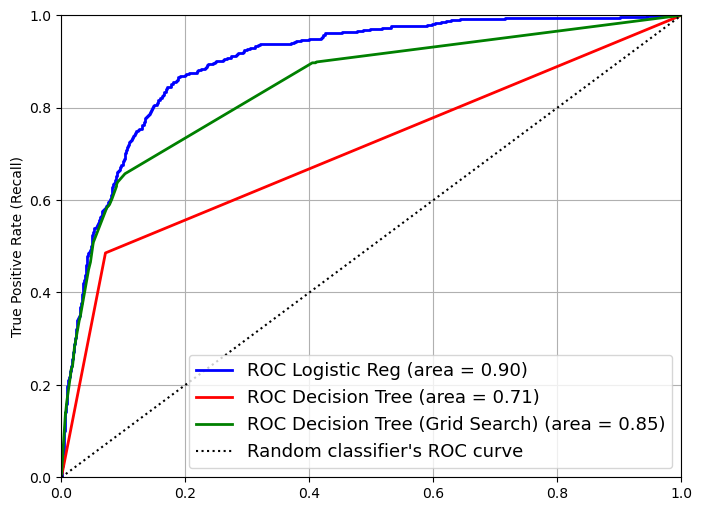

In [17]:
scores1 = log_reg.predict_proba(X_test)
fpr1, tpr1, thresholds = roc_curve(y_test, scores1[:,1], pos_label="yes")
roc_auc1 = auc(fpr1,tpr1)

scores2 = tree_clf.predict_proba(X_test)
fpr2, tpr2, thresholds = roc_curve(y_test, scores2[:,1], pos_label="yes")
roc_auc2 = auc(fpr2,tpr2)

scores3 = grid_search.best_estimator_.predict_proba(X_test)
fpr3, tpr3, thresholds = roc_curve(y_test, scores3[:,1], pos_label="yes")
roc_auc3 = auc(fpr3,tpr3)

plt.figure(figsize=(8, 6))  
plt.plot(fpr1, tpr1, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc1:0.2f})")
plt.plot(fpr2, tpr2, linewidth=2, color= "red", label=f"ROC Decision Tree (area = {roc_auc2:0.2f})")
plt.plot(fpr3, tpr3, linewidth=2, color= "green", label=f"ROC Decision Tree (Grid Search) (area = {roc_auc3:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

print("LogReg AUROC: %.2f" %(roc_auc1))
print("DecisionTree AUROC: %.2f" %(roc_auc2))
print("DecisionTree_GridSearch AUROC: %.2f" %(roc_auc3))